In [1]:
import numpy as np
import dask.array as da
import pandas as pd
from scipy.sparse import coo_matrix, eye
import networkx as nx
import matplotlib.pyplot as plt
import dask_grblas
from dask_grblas import Matrix, Vector, Scalar
from grblas import unary, binary, monoid, semiring, op
from grblas import io as gio

## Connected Components

The code in this notebook is based on the algorithm described in the following paper:
* Yongzhe Zhang, Ariful Azad, Aydin Buluc: *Parallel algorithms for finding connected components using linear algebra*. J. Parallel Distributed Comput. 144: 14-27 (2020).

A prevoius version of the algorithm is here (which might not be reflected in this code):
* Zhang, Azad, Hu. *FastSV: A Distributed-Memory Connected Component Algorithm with Fast Convergence* (SIAM PP20)

## Create and visualize a Matrix

In [2]:
# The input matrix A must be symmetric.  Self-edges (diagonal entries) are
# OK, and are ignored.  The values and type of A are ignored; just its
# pattern is accessed.
row_col = np.array([
    [0, 0, 0, 1, 2, 2, 3, 6, 6,  9,  9],
    [1, 2, 3, 2, 4, 5, 4, 7, 8, 10, 11],
])
rows, cols = row_col
data = np.full_like(rows, fill_value=1)

In [3]:
A = coo_matrix((data, (rows, cols)), shape=(12, 12)).tolil()
A[cols, rows] = A[rows, cols]                  # symmetrize matrix
A = A.tocoo()

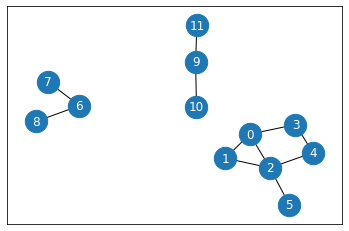

In [4]:
# Draw A using spring layout which may even reveal the connected components
G = nx.convert_matrix.from_scipy_sparse_matrix(A)
layout = nx.drawing.layout.spring_layout(G, k=0.6, scale=1, threshold=1e-10)
nx.draw_networkx(G, with_labels=True, node_size=500, font_color='w', pos=layout)

In [5]:
rows_da = da.from_array(np.concatenate([rows, cols]))
cols_da = da.from_array(np.concatenate([cols, rows]))
data_da = da.from_array(np.concatenate([data, data]))
A = Matrix.from_values(rows_da, cols_da, data_da, nrows=12, ncols=12, chunks=4)
# Size of the sparse matrix is 12x12 with 22 non-zero elements of type INT64
A

In [6]:
(A.nrows, A.ncols)

(12, 12)

In [7]:
A.nvals.compute()

22

In [8]:
A._delayed

dask.array<from_values2D, shape=(12, 12), dtype=int32, chunksize=(4, 4), chunktype=dask_grblas.InnerMatrix>

In [9]:
A.compute()
# This is an adjacency matrix
# Reading along a row shows the out-nodes of a vertex
# Reading along a column shows the in-nodes of a vertex

"M_28"         nvals  nrows  ncols  dtype         format
grblas.Matrix     22     12     12  INT32  bitmapr (iso)
--------------------------------------------------------
   0  1  2  3  4  5  6  7  8  9  10 11
0      1  1  1                        
1   1     1                           
2   1  1        1  1                  
3   1           1                     
4         1  1                        
5         1                           
6                        1  1         
7                     1               
8                     1               
9                                 1  1
10                             1      
11                             1

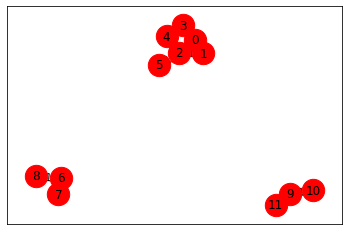

In [10]:
# grblas.io.draw could do with a few more tunable options to improve pretty display
gio.draw(A.compute())

In [11]:
def fastSV(A, chunksz='auto'):
    n = A.nrows
    I = da.arange(n, chunks=chunksz)
    # The parent of each vertex is initialized to be the vertex itself:
    f = Vector.from_values(I, I, name='parents', chunks=chunksz)
    gp = f.dup()        # grandparent of each vertex initialized to parent
    gp_dup = gp.dup()   # duplicate grandparents
    mngp = f.dup()      # minimum grandparent of each star-vertex

    # boolean flag for each vertex
    mod = Vector.new(dtype=bool, size=n, name='modified?', chunks=chunksz)
    # flag to terminate FastSV algorithm
    change = Scalar.from_value(True, dtype=bool, name='changed?')
    
    while change:
        # set checkpoint for task graph
        gp = gp.persist()
        f = f.persist()
        I = I.persist()
        
        # Step 1: Hooking phase
        mngp << A.mxv(gp, semiring.min_second)
        f(binary.min)[I] << mngp
        f << f.ewise_add(mngp, op.min)
        # Step 2: Shortcutting
        f << f.ewise_add(gp, op.min)
        # Step 3: Calculate grandparents
        _, I = f.to_values()
        gp << f[I]
        # Check termination
        mod << gp_dup.ewise_mult(gp, op.ne)
        change << mod.reduce(binary.lor)
        gp_dup << gp

    return f

In [12]:
A = A.persist()
connected_components = fastSV(A, chunksz=4)
connected_components

In [13]:
connected_components._delayed

dask.array<_update_expr, shape=(12,), dtype=int32, chunksize=(4,), chunktype=dask_grblas.InnerVector>

In [14]:
connected_components.compute()

"v_1562"       nvals  size  dtype  format
grblas.Vector     12    12  INT32    full
-----------------------------------------
 0  1  2  3  4  5  6  7  8  9  10 11
  0  0  0  0  0  0  6  6  6  9  9  9

*connected_components* gives the label of the component to which each vertex belongs.

Compare with the graph drawing to check result:

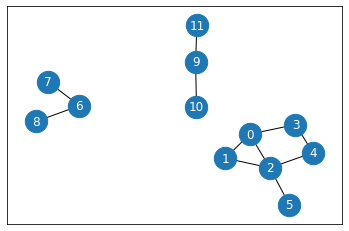

In [15]:
nx.draw_networkx(G, with_labels=True, node_size=500, font_color='w', pos=layout)

Each component has been identified and labeled with the least vertex ID in that component. 

### And that's FastSV in essentially 10 very readable lines of Python, thanks to GraphBLAS